 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..

In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [5]:
observation = 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 2
# Overall Time Period
start_time='2020-08-01' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01' # Begin Vaccination Wave


train_test_split_time= '2021-01-15'


dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs_train, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=train_test_split_time, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs_train[observation], requires_grad=False, device=device, dtype=dtype)

# Initialize Observations Testing
df_obs_test, _ = initialize_observations(df_obs_initial, start=train_test_split_time, end=end_time, rolling_avg=rolling_avg_obs)
observed_test = torch.tensor(df_obs_test[observation], requires_grad=False, device=device, dtype=dtype)

# Create df_obs
observed_train_test = torch.concat((observed_train, observed_test))
df_obs = pd.concat([df_obs_train, df_obs_test])
df_obs = df_obs.reset_index(drop=True)
df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-08-01,0.5,61.0,3.5
1,2020-08-02,0.0,71.0,3.0
2,2020-08-03,0.0,97.5,4.5


In [7]:
#for column in df_obs.columns:
#  plt.plot(df_obs['Date'], df_obs[column])
#  plt.title(column)
#  plt.show()

## Initialize Model Parameter

### Initialize helper parameter

In [8]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [9]:
method = Linear(device=device, dtype=dtype, input_size=5)

### Initialize alpha and phi

In [10]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(0.0102, requires_grad=True),
  'phi': tensor(-0.0020, requires_grad=True)},
 'real_values': {'alpha': tensor(0.0280, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

## Load Method Input Data

In [11]:
input_data_train, input_data_test = get_model_input(start=start_time, end=end_time, split_date=train_test_split_time, path='data/modeling/fa_data_model_input.csv', rolling_avg=7)
input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/fa_data_model_input.csv', rolling_avg=7)
input_data_train.shape

(167, 5)

In [12]:
input_data_test.shape

(17, 5)

In [13]:
input_data.shape

(184, 5)

# Optimization

## Training

In [14]:
from torch.optim.lr_scheduler import ExponentialLR

epochs = 2000
# model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']] + [dict_param['prime_values']['epsilon']]

params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi']]
if observation == 'hospitalization':
  params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)

for i in range(epochs):
  iteration_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  dict_param = transform_prime_variables(dict_param)

  # forward pass
  expected = epid_model(R=method.calculate_R(input_data_train), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation][:df_obs_train.shape[0]]
  
  # calc loss
  comparison_loss_train =  calc_mse(expected, observed_train) * dict_param['real_values']['phi'] #calc_poisson_loss(expected, observed_train) * dict_param['real_values']['phi']# #calc_negative_binomnial_loss(expected, observed_train, dict_param['real_values']['phi']) #
  method_loss = method.calculate_loss()
  model_param_loss = calc_prior_loss(dict_param, device, dtype)
  loss = comparison_loss_train + method_loss + model_param_loss

  # backward pass
  loss.backward()
  optimizer.step()
  scheduler.step()
  
  
  with torch.no_grad():
    if i % 50==0:
        current_time = round((time.time() - iteration_time),4)
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        expected_test = epid_model(R=method.calculate_R(input_data_test), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation][-df_obs_test.shape[0]:]
        print(f"Step: {i}, Learning Rate: {current_lr} Time: {current_time}, Comparison Loss: {comparison_loss_train}")
        plt.plot(df_obs_train['Date'], method.calculate_R(input_data_train).cpu().detach().numpy(), label='R')
        plt.plot(df_obs_train['Date'], input_data_train, label='cluster')
        plt.legend()
        plt.show()
    if i % 100==0:
      plt.plot(df_obs_train['Date'], expected.cpu().detach().numpy(), label='predicted')
      plt.plot(df_obs_train['Date'], observed_train.cpu().detach().numpy(), label='observed')
      plt.legend()
      plt.show()

      expected_train_test = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
      plt.plot(expected_train_test.cpu().detach().numpy(),label='Expected All Data')
      plt.plot(observed_train_test.cpu().detach().numpy(),label='Observed All Data')
      plt.axvline(x=observed_train.shape[0])
      plt.legend()
      plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [15]:
comparison_loss_train / dict_param['real_values']['phi']

tensor(147.2625, grad_fn=<DivBackward0>)

# Evaluation

## Train and Test Time 

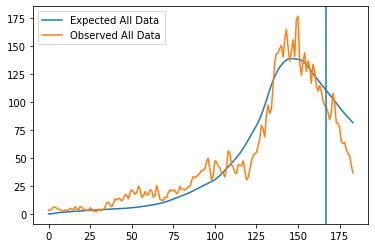

In [16]:
expected_train_test = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
plt.plot(expected_train_test.cpu().detach().numpy(),label='Expected All Data')
plt.plot(observed_train_test.cpu().detach().numpy(),label='Observed All Data')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

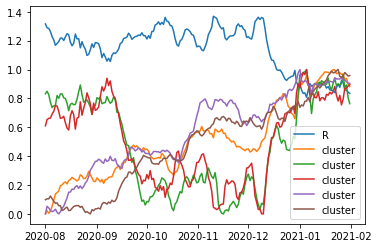

In [17]:
# Plot R-Value & Cluster Percentage
plt.plot(df_obs['Date'], method.calculate_R(input_data).cpu().detach().numpy(), label='R')
plt.plot(df_obs['Date'], input_data, label='cluster')
plt.legend()
plt.show()

## Eval on Test Data


Comparison Loss Train: 3562.03369140625 - Comparison Loss Test: 15835.5556640625


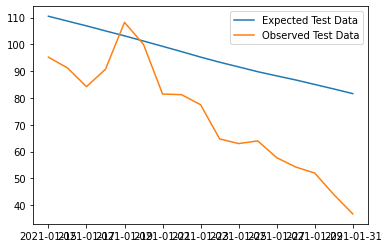

In [18]:
expected_test = expected_train_test[-df_obs_test.shape[0]:]
comparison_loss_test = calc_mse(expected_test, observed_test) * dict_param['real_values']['phi']
print(f'Comparison Loss Train: {comparison_loss_train} - Comparison Loss Test: {comparison_loss_test}')

plt.plot(df_obs_test['Date'], expected_test.cpu().detach().numpy(),label='Expected Test Data')
plt.plot(df_obs_test['Date'], observed_test.cpu().detach().numpy(),label='Observed Test Data')
plt.legend()
plt.show()

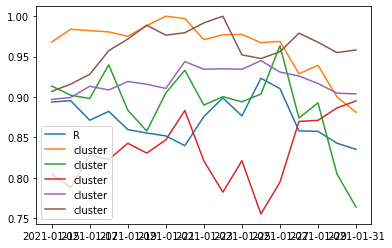

In [19]:
# Plot R-Value & Cluster Percentage
plt.plot(df_obs_test['Date'], method.calculate_R(input_data_test).cpu().detach().numpy(), label='R')
plt.plot(df_obs_test['Date'], input_data_test, label='cluster')
plt.legend()
plt.show()

## Eval What IF

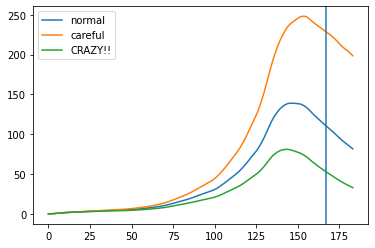

In [20]:
expected_normal = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_careful= epid_model(R=method.calculate_R(input_data*0.9), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_crazy = epid_model(R=method.calculate_R(input_data*1.1), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

plt.plot(expected_normal.cpu().detach().numpy(),label='normal')
plt.plot(expected_careful.cpu().detach().numpy(),label='careful')
plt.plot(expected_crazy.cpu().detach().numpy(),label='CRAZY!!')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()

## Eval Cluster Percentage vs R-Value

In [ ]:
from scipy import stats

x = np.arange(0,1 , 0.01)
y = np.squeeze(method.calculate_R(x).cpu().detach().numpy())


x_min = input_data.min()
x_max = input_data.max()
x_bound = np.arange(x_min, x_max + 0.01 , 0.01)
y_bound = np.squeeze(method.calculate_R(x_bound).cpu().detach().numpy())

slope, intercept, r_value, p_value, std_err = stats.linregress(x_bound, y_bound)
y_linreg = intercept + slope * x_bound
print(f'Slope: {slope}, intercept: {intercept}, r-squared: {r_value**2}')
plt.plot(x, y, label='actual values')
plt.plot(x_bound, y_linreg, label='linear regression')
plt.axvline(x=x_min, c='r', linestyle='--')
plt.axvline(x=x_max, c='r', linestyle='--')
plt.xlabel('Cluster percentage')
plt.ylabel('R Value')
plt.title('Cluster percentage and R Value')
plt.legend()
plt.show()

# Eval Method

In [29]:
from clustering.utils import *

In [30]:
get_factor_cols()

['F0_cautious_behaviour',
 'F1_perception_advice',
 'F2_applicability_usefullness_advice',
 'F3_behaviour_others',
 'F4_consequence_advice']

In [24]:
set(method.model.parameters())

{Parameter containing:
 tensor([1.5077], requires_grad=True), Parameter containing:
 tensor([[-0.3599,  0.2191, -0.6037,  0.0822, -0.0592]], requires_grad=True)}

In [38]:
method.calculate_R(torch.zeros(5).reshape(1, 5))

/content/drive/MyDrive/GitHub/master-thesis/model/methods.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device=self.device, dtype=self.dtype).reshape(-1, self.input_size)


tensor([[1.5077]], grad_fn=<ReluBackward0>)

# Eval Newly Infected

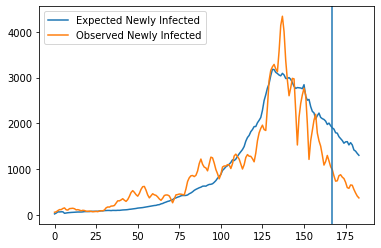

In [21]:
expected_newly = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)['newly_infected']

plt.plot(expected_newly.cpu().detach().numpy(),label='Expected Newly Infected')
plt.plot(df_obs['newly_infected'],label='Observed Newly Infected')
plt.axvline(x=observed_train.shape[0])
plt.legend()
plt.show()